# TUIA - Aprendizaje Automático 1

## Trabajo práctico N°1: Regresión lineal

**CORRECCIONES**

- visual
- nulos latitud y longitud con knn 
- categorizar fechas y cant de pasajeros
- outliers de distancia 
- matriz numérica (ver que columanas poner)
- imprimir coeficientes
- ampliar parámetros de optimización
- optimización de hiperparámetros con cross-validation: lasso, ridge, elasticnet, gradiente (ver pq da raro)


Integrantes:
- Moresco, Brisa
- Brizuela Cipolletti, Sofía

### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [1]:
import pandas as pd
import numpy as np
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from geopy.distance import geodesic
from tabulate import tabulate

In [2]:
# https://drive.google.com/file/d/1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U/view?usp=drive_link
!gdown 1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U

Downloading...
From: https://drive.google.com/uc?id=1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U
To: c:\Users\sbriz\Documents\TUIA\Aprendizaje Automático 1\AA1-TUIA-2025C1-Suarez-BrizuelaCipolletti-Moresco1\uber_fares.csv

  0%|          | 0.00/23.5M [00:00<?, ?B/s]
  2%|▏         | 524k/23.5M [00:00<00:05, 3.99MB/s]
  7%|▋         | 1.57M/23.5M [00:00<00:03, 5.52MB/s]
 13%|█▎        | 3.15M/23.5M [00:00<00:02, 7.99MB/s]
 18%|█▊        | 4.19M/23.5M [00:00<00:02, 8.46MB/s]
 22%|██▏       | 5.24M/23.5M [00:00<00:02, 8.72MB/s]
 29%|██▉       | 6.82M/23.5M [00:00<00:01, 9.43MB/s]
 34%|███▎      | 7.86M/23.5M [00:00<00:01, 9.60MB/s]
 38%|███▊      | 8.91M/23.5M [00:01<00:01, 9.79MB/s]
 42%|████▏     | 9.96M/23.5M [00:01<00:01, 9.82MB/s]
 47%|████▋     | 11.0M/23.5M [00:01<00:01, 9.83MB/s]
 51%|█████▏    | 12.1M/23.5M [00:01<00:01, 9.89MB/s]
 56%|█████▌    | 13.1M/23.5M [00:01<00:01, 9.89MB/s]
 63%|██████▎   | 14.7M/23.5M [00:01<00:00, 10.2MB/s]
 69%|██████▉   | 16.3M/23.5M [00:01<00:00, 10.4MB/s]
 74

# Información del dataset

In [3]:
# Carga del dataset
df = pd.read_csv("./uber_fares.csv", sep=',', encoding='latin-1', on_bad_lines='warn')

In [4]:
# Visualización del dataset
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
### Columnas, ¿cuáles son variables numéricas y cuáles variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
# Contamos los valores faltantes en cada columna
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [8]:
# Como se ve que hay valores nulos en dropoff_longitude y dropoff_latitude solamente, validamos si son sobre el mismo registro
# True -> Un único registro

missing_rows = df[df[['dropoff_longitude', 'dropoff_latitude']].isnull().any(axis=1)]
print(len(missing_rows) == 1)

True


In [9]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


## Imputación KNN

In [10]:
# Cuento los valores faltantes en cada columna
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [11]:
# Seleccionamos columnas relevantes para la imputación
columns_for_imputation = [
    'dropoff_longitude', 'dropoff_latitude',
]

# Creamos el imputador con k=5 vecinos 
imputer = KNNImputer(n_neighbors=5)

# Aplicamos el imputador
df[columns_for_imputation] = imputer.fit_transform(df[columns_for_imputation])

# Verificamos si aún quedan nulos
print("Valores faltantes después de KNNImputer:\n", df.isnull().sum())

Valores faltantes después de KNNImputer:
 key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [12]:
# Eliminamos las variables 'key' y 'date' ya que son columnas que no aportan información relevante para la predicción
df = df.drop(columns=['key', 'date'])

### Variable target 'fare_amount'

In [13]:
# Contabilizamos los viajes que presentan valores negativos o iguales a 0 en la variable target
df[df['fare_amount'] <= 0].value_counts().sum()

np.int64(22)

In [14]:
# Eliminamos las filas que tengan un valor negativo en la variable target (fare_amount)
df = df[df['fare_amount'] > 0]

In [15]:
df.fare_amount.describe()

count    199978.000000
mean         11.362649
std           9.897079
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

# Gráficos

- A continuación se visualizan distribuciones de tarifas, días de la semana, horas, y se analiza la cantidad de viajes por hora y día a través de gráficos como boxplots, histogramas y heatmaps. Además,  se clasifican las franjas horarias del día, se limpian valores atípicos en la cantidad de pasajeros, y se agrupan los tipos de viaje (Uber, UberEats, UberXL).

- Luego, se calcula la distancia entre el origen y el destino de los viajes utilizando coordenadas geográficas.
Por último, visualizamos las coordenadas de origen y destino en mapas de calor para identificar áreas de alta densidad de viajes.

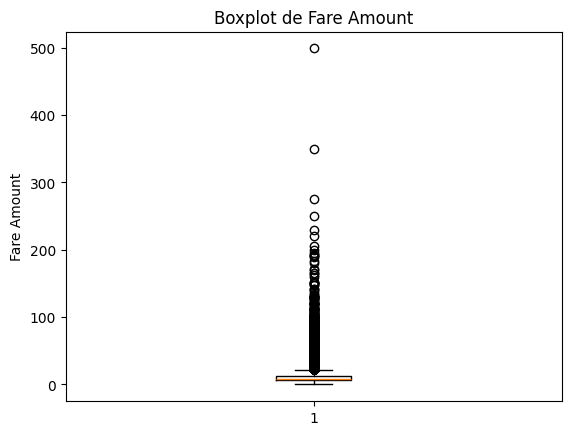

In [16]:
# Boxplot de la variable target
plt.boxplot(df['fare_amount'])
plt.title('Boxplot de Fare Amount')
plt.ylabel('Fare Amount')
plt.show()

### Análisis temporal

In [17]:
# Convertimos la variable 'pickup_datetime' a tipo datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Eliminamos los decimales de los segundos
df['pickup_datetime'] = df['pickup_datetime'].dt.floor('s')

# A partir de esa variable, separamos en año, mes, día de la semana y hora
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

In [18]:
# Creamos una variable 'weekend' para determinar si el viaje fue durante un fin de semana o no
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [4, 6] else 0)

In [19]:
# Buscamos los feriados del estado de Nueva York
holidays_ny = holidays.US(state='NY')

In [20]:
# También creamos una variable 'holiday' para determinar si ese día fue feriado o no
df['holiday'] = df['pickup_datetime'].apply(lambda x: 1 if x in holidays_ny else 0)

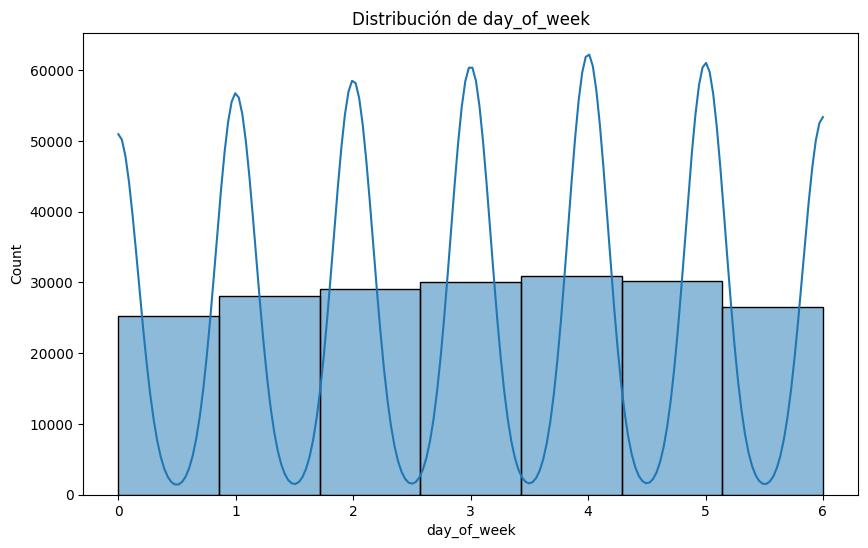

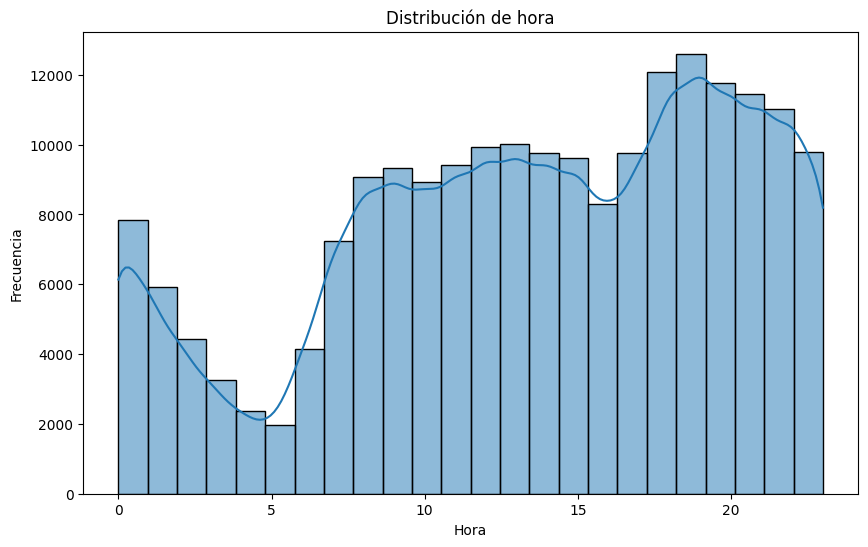

In [21]:
# Histograma del día de la semana
plt.figure(figsize=(10, 6))
sns.histplot(df['day_of_week'], bins=7, kde=True)
plt.title('Distribución de day_of_week')
plt.show()

# Histograma de la hora
plt.figure(figsize=(10, 6))
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Distribución de hora')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.show()

Text(0.5, 0, '¿Es feriado?')

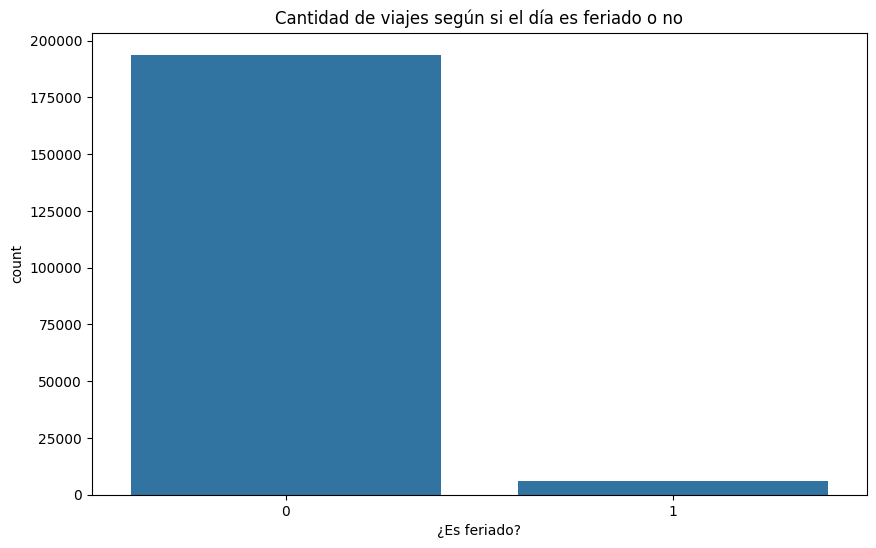

In [22]:
# Cantidad de viajes según si el día es feriado o no
plt.figure(figsize=(10, 6))
sns.countplot(x='holiday', data=df)
plt.title('Cantidad de viajes según si el día es feriado o no')
plt.xlabel('¿Es feriado?')

Observamos que la mayor cantidad de viajes se realizan en días que no son feriados

Text(0.5, 0, '¿Es fin de semana?')

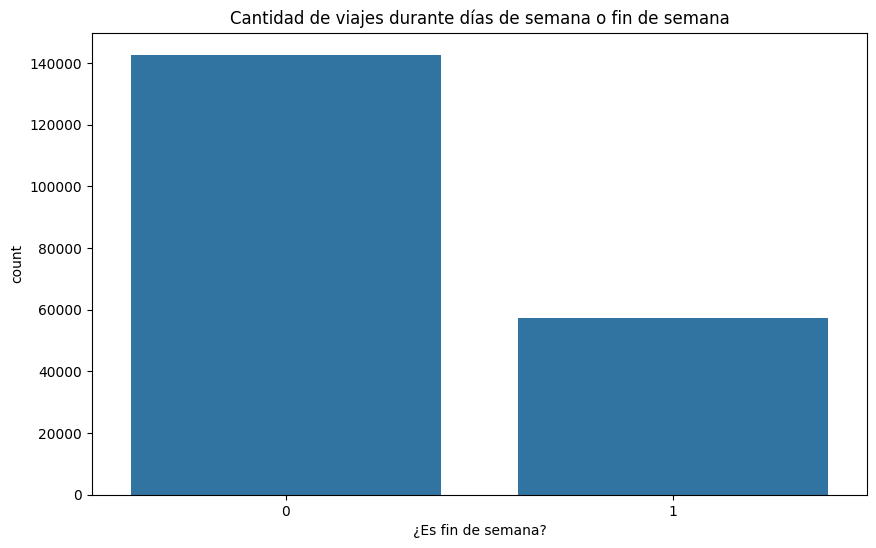

In [23]:
# Cantidad de viajes durante días de semana o fin de semana
plt.figure(figsize=(10, 6))
sns.countplot(x='weekend', data=df)
plt.title('Cantidad de viajes durante días de semana o fin de semana')
plt.xlabel('¿Es fin de semana?')

A partir del gráfico, podemos deducir que la mayoría de los viajes ocurren durante los días de semana, más del doble de la cantidad que suceden durante los fines de semana

### Heatmap de hora y día de la semana para visualizar a qué hora del día se realizan una mayor cantidad de viajes


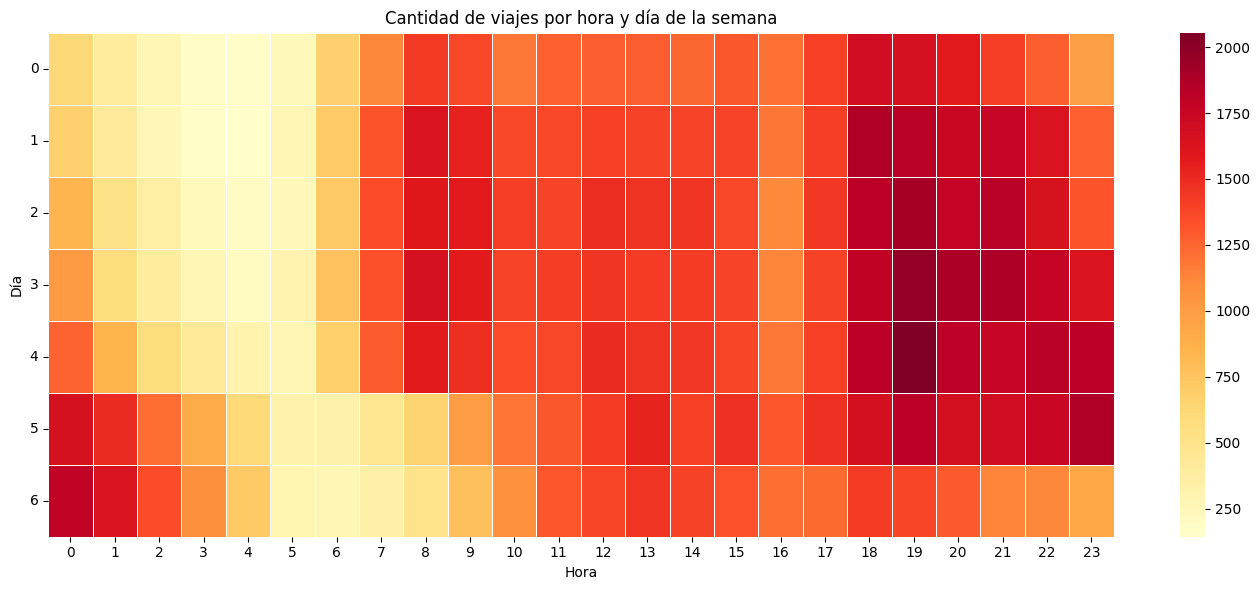

In [24]:
viajes_hora_dia = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(viajes_hora_dia, cmap='YlOrRd', linewidths=.5)
plt.title('Cantidad de viajes por hora y día de la semana')
plt.xlabel('Hora')
plt.ylabel('Día')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Promedio de tarifas por día y hora

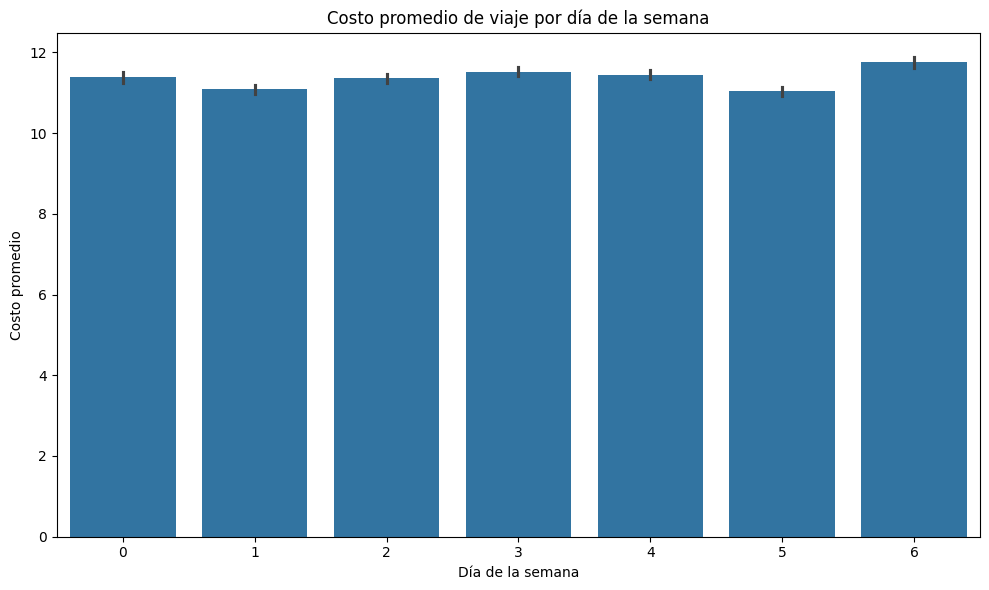

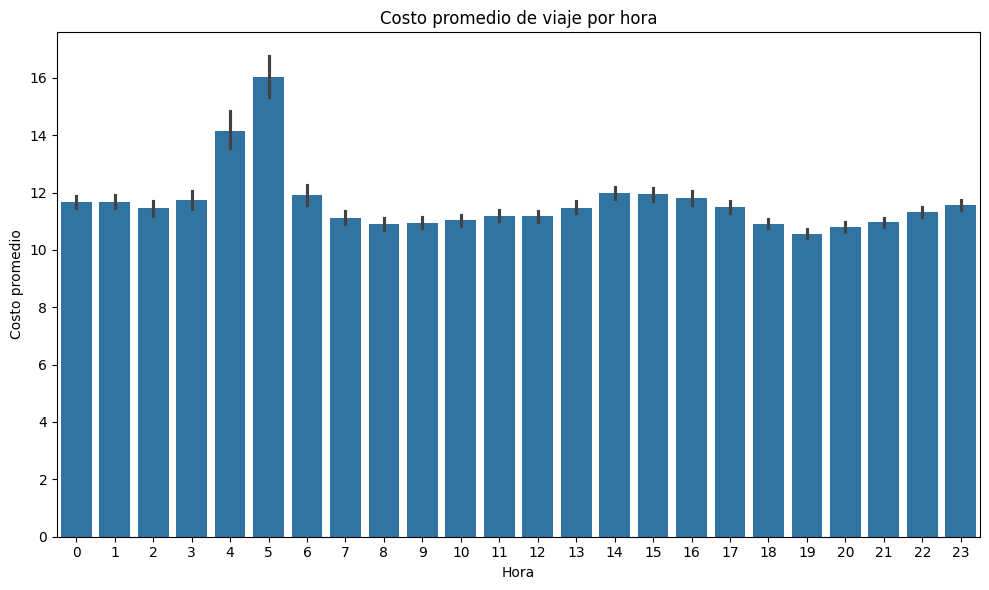

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='fare_amount', data=df)
plt.title('Costo promedio de viaje por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Costo promedio')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='fare_amount', data=df)
plt.title('Costo promedio de viaje por hora')
plt.xlabel('Hora')
plt.ylabel('Costo promedio')
plt.tight_layout()
plt.show()


### Clasificación por franja horaria (day_time)

In [26]:
df['day_time'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['madrugada', 'mañana', 'tarde', 'noche'],
    right=False
)

df = pd.get_dummies(df, columns=['day_time'])
print(df.filter(like='day_time_').head())

   day_time_madrugada  day_time_mañana  day_time_tarde  day_time_noche
0               False            False           False            True
1               False            False           False            True
2               False            False           False            True
3               False             True           False           False
4               False            False            True           False


In [42]:
# Convertir columnas dummies de 'day_time' a enteros
day_time_dummies = [col for col in df.columns if col.startswith('day_time_')]
df[day_time_dummies] = df[day_time_dummies].astype(int)

###  **Tratamiento de la cantidad de pasajeros**

* Primero, analizamos la distribución de la variable `passenger_count` y detectamos valores atípicos (mayores a 6), que fueron reemplazados por la mediana.
* Luego, generamos una nueva variable, la cual se codifica para integrarla correctamente al modelo:
  * `uber_type`: categoriza los viajes en Uber, UberXL o UberEats según la cantidad de pasajeros.




In [27]:
print(df.passenger_count.describe())  # Observación de outliers

count    199978.000000
mean          1.684480
std           1.385974
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64


Se observa que hay un valor de 208 como máximo, lo cual es un outlier y debería ser reemplazado por la mediana

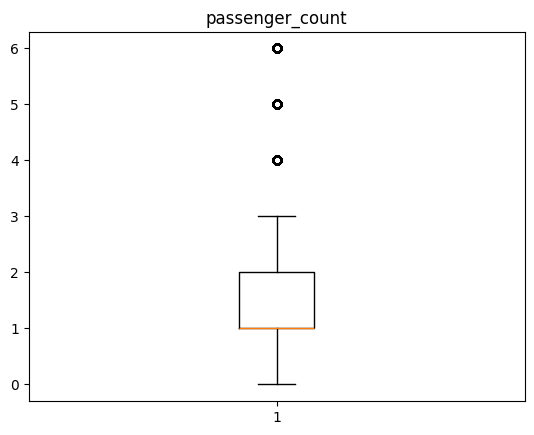

In [28]:
# Reemplazo de valores outliers
df.loc[df['passenger_count'] > 6, 'passenger_count'] = df['passenger_count'].median()

# Boxplot
plt.boxplot(df['passenger_count'])
plt.title('passenger_count')
plt.show()

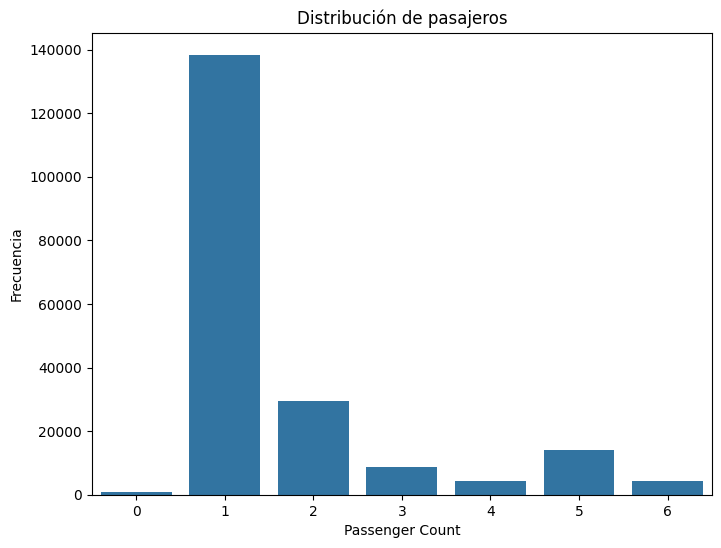

In [29]:
# Conteo por número de pasajeros
plt.figure(figsize=(8, 6))
sns.countplot(x='passenger_count', data=df)
plt.title('Distribución de pasajeros')
plt.xlabel('Passenger Count')
plt.ylabel('Frecuencia')
plt.show()

### Clasificación del tipo de viaje (uber_type)

In [30]:
df['uber_type'] = df['passenger_count'].apply(lambda x: 'UberEats' if x == 0 else ('UberX' if x <= 4 else 'UberXL'))
df = pd.get_dummies(df, columns=['uber_type'])

In [40]:
# Convertir columnas dummies de 'uber_type' a enteros
uber_dummies = [col for col in df.columns if col.startswith('uber_type_')]
df[uber_dummies] = df[uber_dummies].astype(int)

## Coordenadas y distancia del viaje

Función para calcular la distancia a partir de las latitudes y longitudes del origen y del destino

In [33]:
def calcular_distancia(row):
    return geodesic((row['pickup_latitude'], row['pickup_longitude']),
                    (row['dropoff_latitude'], row['dropoff_longitude'])).km

####  Limpieza de coordenadas

In [31]:
# Limpieza de coordenadas nulas y recorte por límites válidos de NYC
#df['dropoff_longitude'].fillna(df['dropoff_longitude'].median(), inplace=True)
#df['dropoff_latitude'].fillna(df['dropoff_latitude'].median(), inplace=True)

# Límites razonables para coordenadas en NYC
lon_min, lon_max = -74.3, -73.6
lat_min, lat_max = 40.5, 41.0

# Recorte de coordenadas a los límites válidos
df['pickup_longitude'] = np.clip(df['pickup_longitude'], lon_min, lon_max)
df['pickup_latitude'] = np.clip(df['pickup_latitude'], lat_min, lat_max)
df['dropoff_longitude'] = np.clip(df['dropoff_longitude'], lon_min, lon_max)
df['dropoff_latitude'] = np.clip(df['dropoff_latitude'], lat_min, lat_max)

In [34]:
df['trip_distance_km'] = df.apply(calcular_distancia, axis=1)

In [35]:
# Eliminación de outliers de distancia
# Decidimos eliminar viajes demasiado largos (>30 km) o nulos (<0.1 km)
df = df[(df['trip_distance_km'] >= 0.1) & (df['trip_distance_km'] <= 30)]

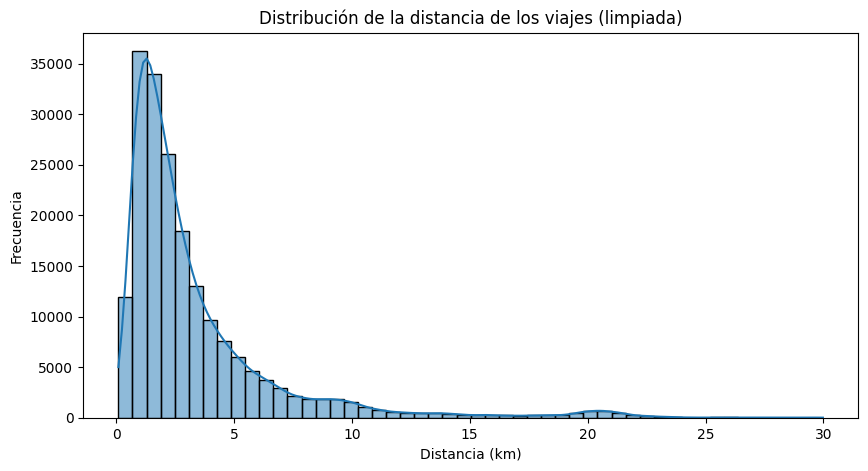

In [36]:
# Visualización de distribución final
plt.figure(figsize=(10, 5))
sns.histplot(df['trip_distance_km'], bins=50, kde=True)
plt.title("Distribución de la distancia de los viajes (limpiada)")
plt.xlabel("Distancia (km)")
plt.ylabel("Frecuencia")
plt.show()

Se eliminaron viajes cuya distancia era menor a 100 metros (posibles errores o viajes cancelados) y mayores a 30 km, ya que representan casos atípicos poco frecuentes en el contexto urbano de NYC. Esto ayuda a reducir el sesgo en el modelo y mejora la calidad del análisis.

### Histogramas de coordenadas

 - Se visualizan las coordenadas de origen y destino en mapas de calor para identificar áreas de alta densidad de viajes.



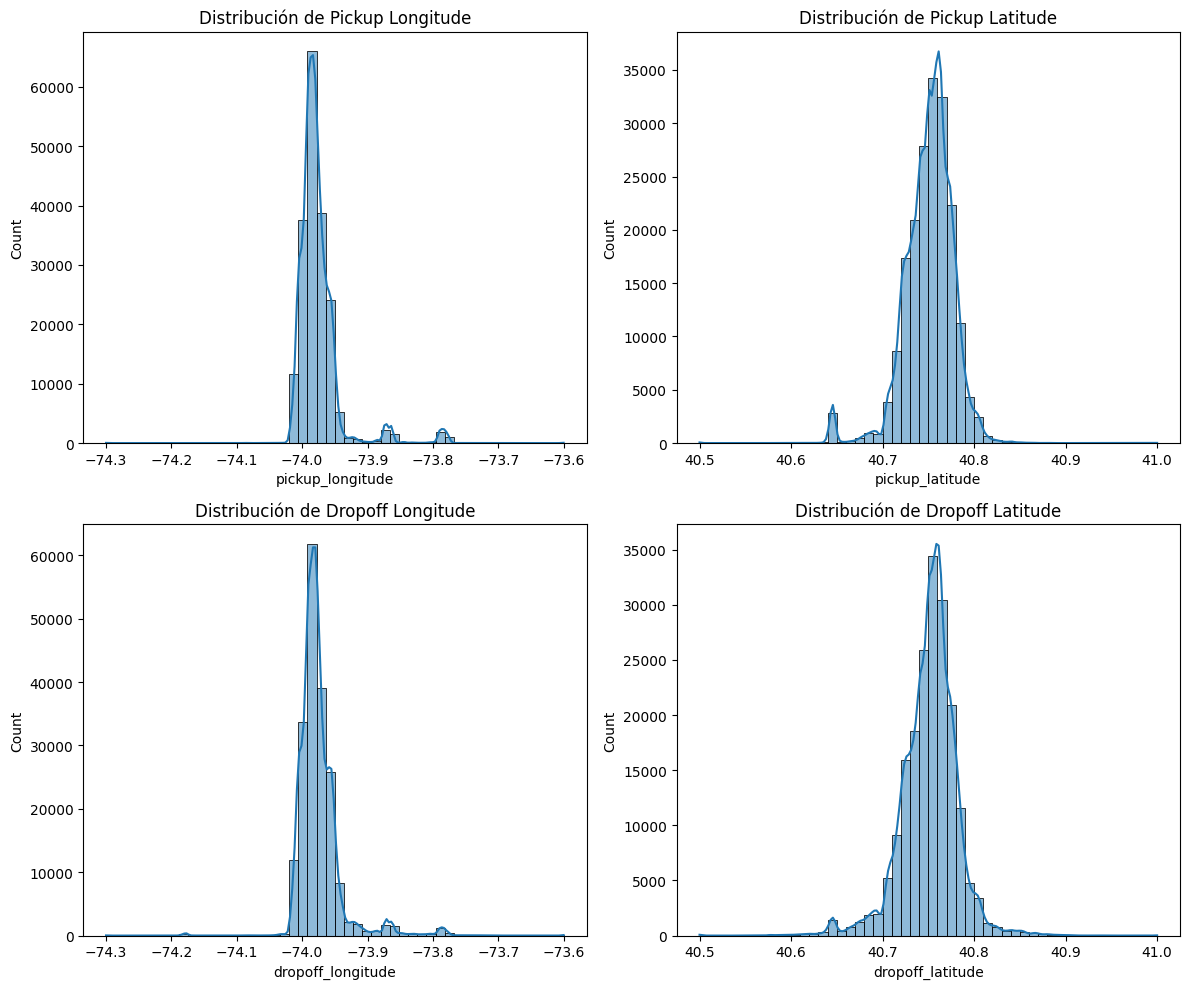

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['pickup_longitude'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Pickup Longitude')
sns.histplot(df['pickup_latitude'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Pickup Latitude')
sns.histplot(df['dropoff_longitude'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Dropoff Longitude')
sns.histplot(df['dropoff_latitude'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Dropoff Latitude')
plt.tight_layout()
plt.show()

Se puede ver que en la latitud y longitud de origen y destino hay rangos donde se aglomeran los datos, esto nos hace suponer que hay sectores de NY donde se aglomeran los viajes.
Usamos mapas de calor para validar este supuesto.

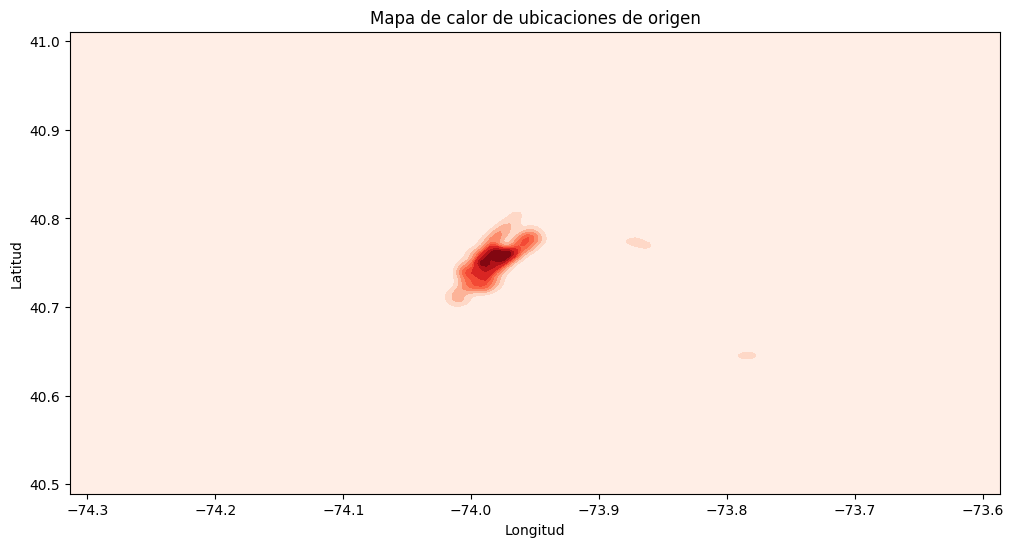

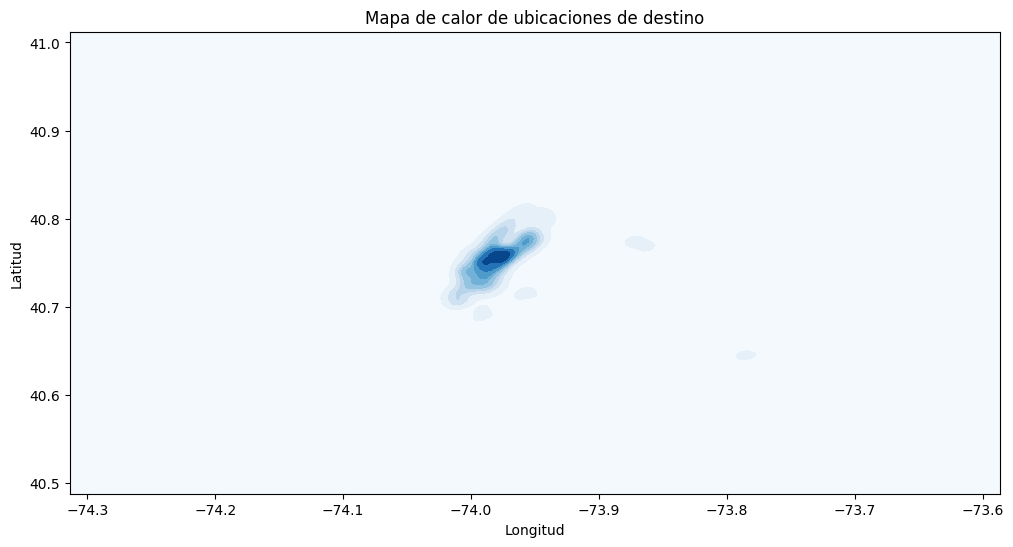

In [38]:
plt.figure(figsize=(12, 6))
sns.kdeplot(x=df['pickup_longitude'], y=df['pickup_latitude'], cmap='Reds', fill=True, thresh=0)
plt.title('Mapa de calor de ubicaciones de origen')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], cmap='Blues', fill=True, thresh=0)
plt.title('Mapa de calor de ubicaciones de destino')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

# Dummies

###  **Transformación de fechas**

Ya que, anteriormente, convertimos la columna `pickup_datetime` al formato datetime,y luego extrajimos la siguiente información útil para el modelo:
* **Hora del día**, **día de la semana** y **mes**, que pueden influir en la tarifa.
* También creamos una **franja horaria categórica** (`mañana`, `tarde`, `noche`, `madrugada`) para capturar patrones de comportamiento temporal.

Decidimos también transformar estas variables en **dummies** para que puedan ser utilizadas en modelos de regresión sin generar multicolinealidad, por lo cual vamos a crear variables de períodos para años y meses.


In [36]:
def preparar_datos_uber(df):
    # Crear columna de trimestres
    def obtener_trimestre(mes):
        if mes in [1, 2, 3]:
            return '1'
        elif mes in [4, 5, 6]:
            return '2'
        elif mes in [7, 8, 9]:
            return '3'
        else:
            return '4'

    df['trimestre'] = df['month'].apply(obtener_trimestre)

    # Crear columna de periodos de años
    def categorizar_anio(anio):
        if 2009 <= anio <= 2010:
            return '2009-2010'
        elif 2011 <= anio <= 2013:
            return '2011-2013'
        elif 2014 <= anio <= 2015:
            return '2014-2015'

    df['periodo_anio'] = df['year'].apply(categorizar_anio)

    # Crear variables dummies
    df = pd.get_dummies(df, columns=['trimestre', 'periodo_anio'], drop_first=False)

    return df

# Llamada a la función con nuestro dataframe
df = preparar_datos_uber(df)

# Verificar las columnas dummy creadas
dummies_cols = [col for col in df.columns if any(prefix in col for prefix in ['trimestre_', 'periodo_anio_', 'day_of_week_', 'month_'])]
print("Columnas dummies:", dummies_cols)

# Eliminar duplicados de la lista de columnas dummies
dummies_cols = list(pd.unique(dummies_cols))

# Verifica las columnas seleccionadas para conversión
print("Columnas seleccionadas para conversión:", dummies_cols)

# Convertir las columnas dummies de True/False a 0/1
df[dummies_cols] = df[dummies_cols].astype(int)

# Verifica el resultado
df.head()

Columnas dummies: ['trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4', 'periodo_anio_2009-2010', 'periodo_anio_2011-2013', 'periodo_anio_2014-2015']
Columnas seleccionadas para conversión: ['trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4', 'periodo_anio_2009-2010', 'periodo_anio_2011-2013', 'periodo_anio_2014-2015']


C:\Users\sbriz\AppData\Local\Temp\ipykernel_17996\1448138983.py:39: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  dummies_cols = list(pd.unique(dummies_cols))


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,uber_type_UberX,uber_type_UberXL,trip_distance_km,trimestre_1,trimestre_2,trimestre_3,trimestre_4,periodo_anio_2009-2010,periodo_anio_2011-2013,periodo_anio_2014-2015
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,...,True,False,1.681111,0,1,0,0,0,0,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,...,True,False,2.454363,0,0,1,0,1,0,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,...,True,False,5.039603,0,0,1,0,1,0,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,...,True,False,1.661442,0,1,0,0,1,0,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,...,False,True,4.483730,0,0,1,0,0,0,1


In [37]:
# Eliminar columnas originales que ya no son necesarias
df.drop(columns=['hour', 'day_of_week', 'month', 'year', 'passenger_count'], inplace=True)

In [43]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weekend,holiday,day_time_madrugada,day_time_mañana,...,uber_type_UberX,uber_type_UberXL,trip_distance_km,trimestre_1,trimestre_2,trimestre_3,trimestre_4,periodo_anio_2009-2010,periodo_anio_2011-2013,periodo_anio_2014-2015
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,0,0,0,0,...,1,0,1.681111,0,1,0,0,0,0,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0,0,0,...,1,0,2.454363,0,0,1,0,1,0,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,0,0,0,0,...,1,0,5.039603,0,0,1,0,1,0,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1,0,0,1,...,1,0,1.661442,0,1,0,0,1,0,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,0,0,0,0,...,0,1,4.483730,0,0,1,0,0,0,1


# Matriz de correlación Numérica

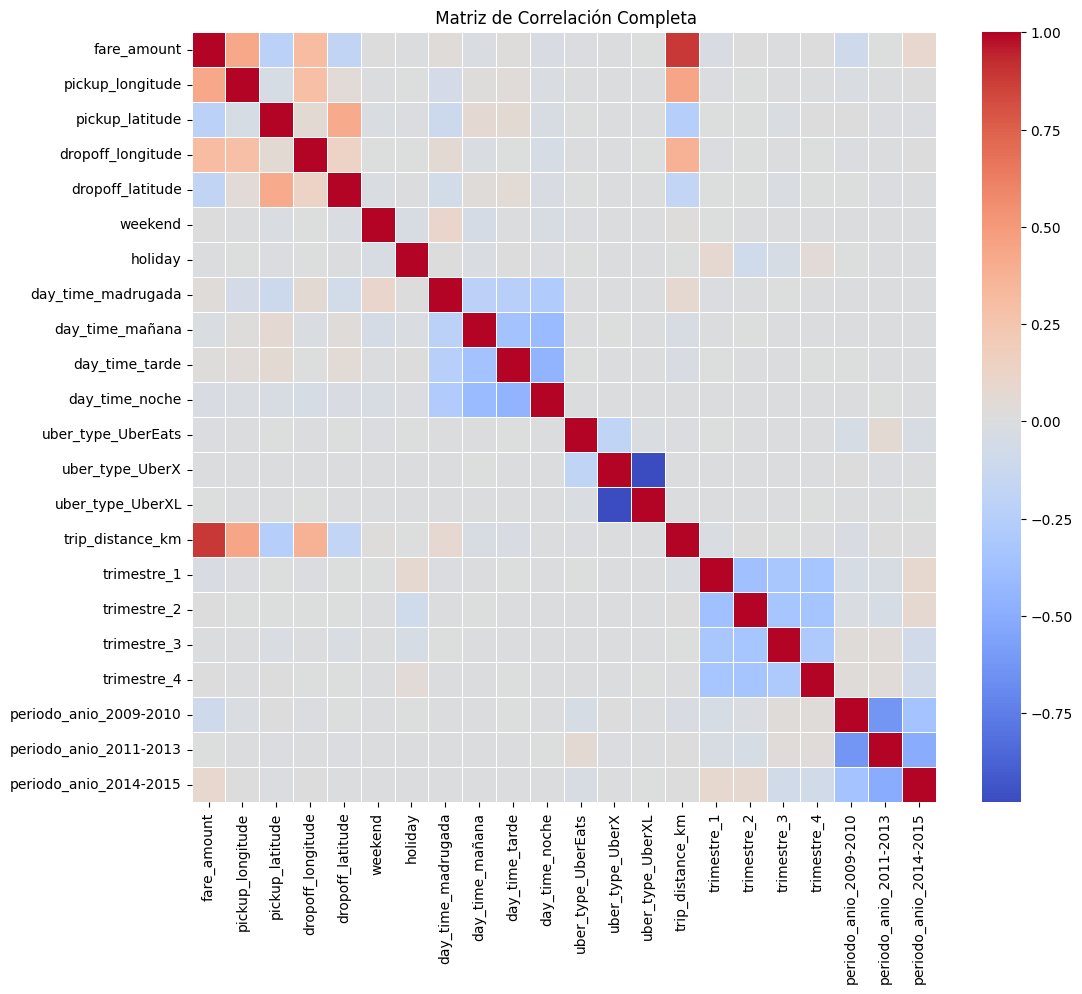

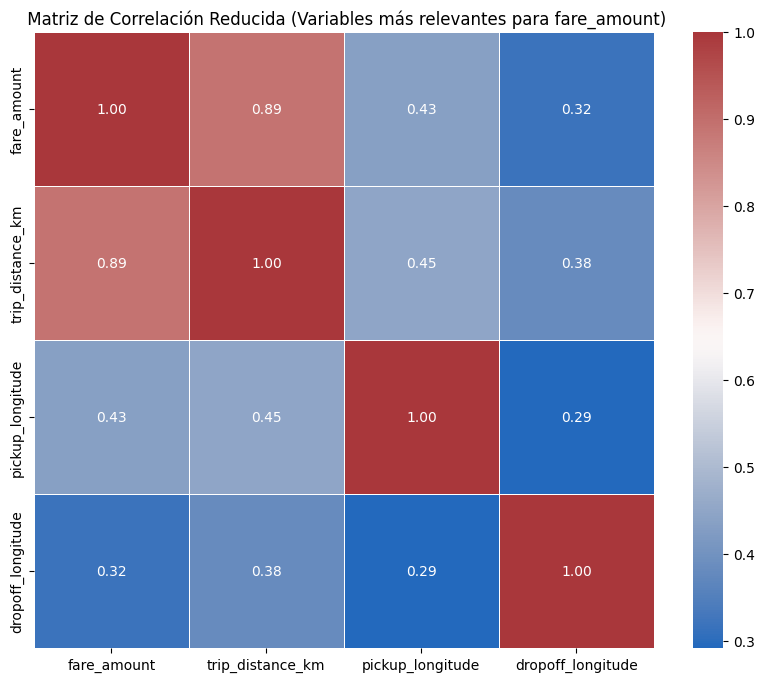

In [44]:
# Seleccionamos solo las variables numéricas (evitamos object y datetime)
df_numerico = df.select_dtypes(include=['int64', 'float64'])

# Calculamos la matriz de correlación completa
correlation_matrix = df_numerico.corr()

# Visualizamos toda la matriz para tener una idea general
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(' Matriz de Correlación Completa')
plt.show()

# Filtramos columnas con correlación fuerte con la variable target (fare_amount)
umbral = 0.3  # Se considera correlación moderada si r > 0.3
correlaciones_fuertes = correlation_matrix['fare_amount'].abs().sort_values(ascending=False)
columnas_fuertes = correlaciones_fuertes[correlaciones_fuertes > umbral].index.tolist()

# Mostramos solo esas variables en una matriz reducida
df_reducido = df[columnas_fuertes]
correlation_matrix_reducida = df_reducido.corr()

# Visualizamos la matriz reducida
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_reducida, annot=True, cmap='vlag', fmt='.2f', linewidths=0.5)
plt.title(' Matriz de Correlación Reducida (Variables más relevantes para fare_amount)')
plt.show()

###  Justificación de mejoras:

* Usamos **solo variables numéricas** reales (`select_dtypes`) para evitar errores o columnas dummy innecesarias.
* Visualizamos **toda la matriz** primero para tener contexto, pero luego hacemos un **zoom a lo relevante**.
* Seleccionamos las variables que tengan **correlación ≥ 0.3** con la variable objetivo, lo cual es un umbral razonable para problemas de regresión.
* Se utiliza un **colormap más contrastante** (`vlag`) para destacar mejor los signos de la correlación.
* El código está mejor comentado y más estructurado para que sea entendible y reutilizable.


**Conclusión (Matriz de Correlación)**
La variable objetivo fare_amount muestra mayor correlación con trip_distance_km, como era esperable. Otras variables como passenger_cat_5 y franja_horaria_noche tienen correlaciones más débiles. Las coordenadas (pickup/dropoff) no aportan mucho por sí solas, ya que la distancia ya está calculada.

En general, las correlaciones son bajas, lo que indica poca multicolinealidad, y las dummies creadas fueron bien manejadas con drop_first=True.

# División del dataset y estandarización

In [45]:
# Quitar target y columnas datetime
X = df.drop(columns=['fare_amount'])                   # quito la target
X = X.select_dtypes(include=['int64', 'float64', 'uint8'])  # me quedo solo con columnas escalables
y = df['fare_amount']

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verificación
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("'fare_amount' en X:", 'fare_amount' in X.columns)  # DEBE dar False

X_train_scaled: (154068, 21)
y_train: (154068,)
'fare_amount' en X: False


# Modelos de regresión

### Regresión lineal

In [46]:
# Entrenamos el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


La validación cruzada se hace solo con los datos de entrenamiento, para evitar "filtraciones" de test.

In [47]:
# Validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"\nR² promedio de validación cruzada (5 folds): {cv_scores.mean():.4f}")
print(f"R² por fold: {cv_scores}")


R² promedio de validación cruzada (5 folds): 0.8064
R² por fold: [0.80795039 0.80310163 0.80069461 0.8108409  0.80919003]


In [48]:
# Predicciones
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

In [49]:
# Métricas para regresión lineal
def print_metrics(y_true, y_pred, dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nMétricas de {dataset_type}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

print_metrics(y_train, y_pred_train, 'Train')
print_metrics(y_test, y_pred_test, 'Test')


Métricas de Train
MSE : 16.86
RMSE: 4.11
MAE : 2.15
R²  : 0.8066

Métricas de Test
MSE : 16.55
RMSE: 4.07
MAE : 2.17
R²  : 0.8195


### Visualización


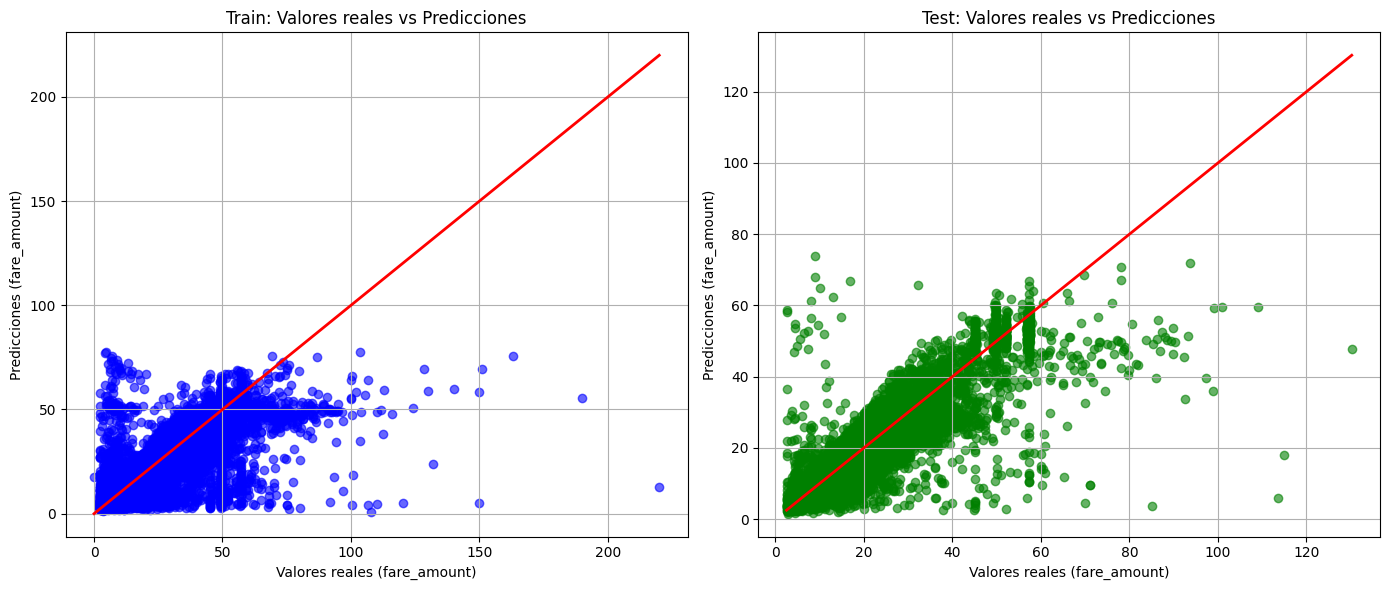

In [50]:
# Gráfica de predicciones vs valores reales para el conjunto de train y test
plt.figure(figsize=(14, 6))

# Gráfico para el conjunto de train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Train: Valores reales vs Predicciones')
plt.xlabel('Valores reales (fare_amount)')
plt.ylabel('Predicciones (fare_amount)')
plt.grid(True)

# Gráfico para el conjunto de test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Test: Valores reales vs Predicciones')
plt.xlabel('Valores reales (fare_amount)')
plt.ylabel('Predicciones (fare_amount)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Gradiente descendiente

- Es un algoritmo de optimización iterativo que busca minimizar una función de pérdida.

In [51]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    # Asegura que y_train e y_val tengan forma de vectores columna (necesario para la multiplicación matricial)
    y_train = np.array(y_train).reshape(-1, 1)
    y_val = np.array(y_val).reshape(-1, 1)

    # Obtiene el número de muestras (n) y características (m) en el conjunto de entrenamiento
    n, m = X_train.shape

    # Obtiene el número de muestras del conjunto de validación (o)
    o = X_val.shape[0]

    # Añade una columna de unos al inicio de X_train y X_val para incluir el término independiente (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Inicializa los pesos (W) aleatoriamente, uno por cada característica + 1 para el bias
    W = np.random.randn(m + 1, 1)

    # Listas para registrar el error cuadrático medio en cada época
    train_errors = []
    val_errors = []

    # Bucle principal: realiza el proceso de entrenamiento durante 'epochs' iteraciones
    for epoch in range(epochs):
        # Calcula las predicciones para el conjunto de entrenamiento usando multiplicación matricial
        prediction_train = X_train @ W  # @ = multiplicación de matrices

        # Calcula el error de las predicciones (real - predicho)
        error_train = y_train - prediction_train

        # Calcula el error cuadrático medio (MSE) y lo guarda
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # lo mismo para el conjunto de validación
        prediction_val = X_val @ W
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

        # Calcula el gradiente del error respecto a los pesos
        gradient = (-2 / n) * (X_train.T @ error_train)

        # Actualiza los pesos restando el gradiente escalado por la tasa de aprendizaje
        W = W - lr * gradient

    # Una vez entrenado, se grafican los errores de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio (MSE)')
    plt.title('Error de entrenamiento y validación vs Épocas (Gradiente Descendente)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Devuelve los pesos entrenados y los errores para posible análisis posterior
    return W, train_errors, val_errors

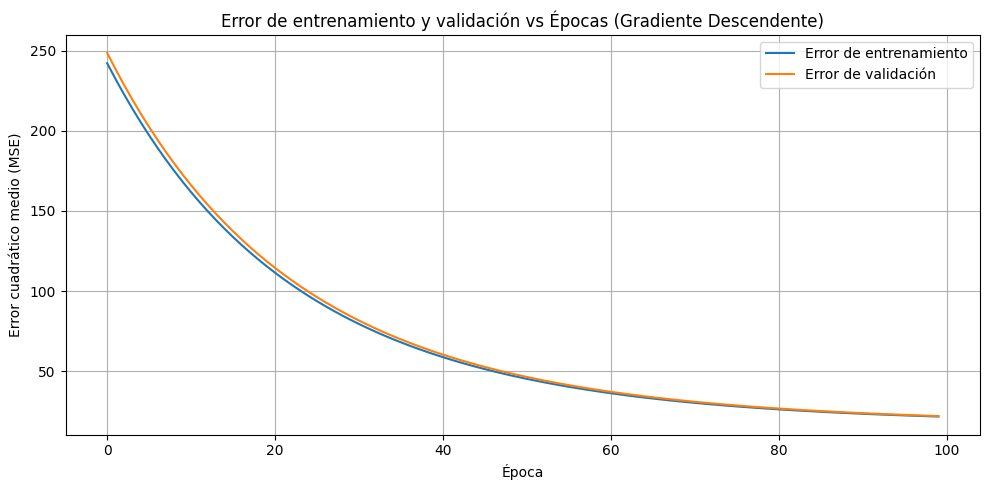

Pesos entrenados: [ 9.53705189  0.75500712 -0.2641305   0.77874313 -0.69896108  0.05832455
 -0.18987697  0.23126047  0.68143191  0.92627178  0.55455379  0.0358074
  0.15162268  0.17039824  6.73817044 -0.27200595 -0.22455315 -0.12785368
 -0.03544508 -0.21018538  0.33984133  0.93532003]
Último error de entrenamiento: 21.69797039765316
Último error de validación: 21.987694801007336


In [52]:
# Ejecutar gradiente descendente con los datos escalados
W, train_errors, val_errors = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test)

# Mostrar resultados
print("Pesos entrenados:", W.ravel())
print("Último error de entrenamiento:", train_errors[-1])
print("Último error de validación:", val_errors[-1])

El modelo entrenado con gradiente descendente converge de manera estable y logra un buen desempeño tanto en entrenamiento como en validación. La proximidad entre los errores indica una buena capacidad de generalización, lo que demuestra que el aprendizaje fue efectivo sin sobreajuste

# Métodos de regularización

Achica los coeficientes menos significativos para reducir la varianza y
mejorar el modelo.


In [53]:
# funcion para imprimir metricas
def print_metrics(y_true, y_pred, model_name='Modelo', dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n {model_name} - {dataset_type}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²  : {r2:.4f}")

In [54]:
def print_coefficients(model, feature_names=None, model_name="Modelo"):
    print(f"\n Coeficientes - {model_name}")
    coef = model.coef_.flatten() if hasattr(model.coef_, "flatten") else model.coef_
    if feature_names is not None:
        for name, c in zip(feature_names, coef):
            print(f"{name:>25}: {c:.4f}")
    else:
        for i, c in enumerate(coef):
            print(f"x{i:>2}: {c:.4f}")
    print(f"Intercepto: {model.intercept_:.4f}")

In [55]:
# Aseguramos tener los nombres correctos
feature_names = X.columns

### Lasso

In [56]:
# --- Lasso ---
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_train_lasso = lasso.predict(X_train_scaled)
y_test_lasso = lasso.predict(X_test_scaled)

print_metrics(y_train, y_train_lasso, model_name='Lasso', dataset_type='Train')
print_metrics(y_test, y_test_lasso, model_name='Lasso', dataset_type='Test')
print_coefficients(lasso, feature_names=feature_names, model_name="Lasso")


 Lasso - Train
MSE : 16.99
RMSE: 4.12
MAE : 2.14
MAPE: 21.55%
R²  : 0.8051

 Lasso - Test
MSE : 16.81
RMSE: 4.10
MAE : 2.17
MAPE: 20.20%
R²  : 0.8167

 Coeficientes - Lasso
         pickup_longitude: 0.3246
          pickup_latitude: 0.0000
        dropoff_longitude: -0.0299
         dropoff_latitude: -0.2461
                  weekend: -0.0000
                  holiday: -0.0000
       day_time_madrugada: -0.2165
          day_time_mañana: 0.0000
           day_time_tarde: 0.1780
           day_time_noche: -0.0935
       uber_type_UberEats: -0.0000
          uber_type_UberX: -0.0000
         uber_type_UberXL: 0.0000
         trip_distance_km: 8.0364
              trimestre_1: -0.0156
              trimestre_2: -0.0000
              trimestre_3: 0.0000
              trimestre_4: 0.0866
   periodo_anio_2009-2010: -0.3511
   periodo_anio_2011-2013: 0.0000
   periodo_anio_2014-2015: 0.5365
Intercepto: 11.2683


### Ridge

In [57]:
# --- Ridge ---
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_train_ridge = ridge.predict(X_train_scaled)
y_test_ridge = ridge.predict(X_test_scaled)

print_metrics(y_train, y_train_ridge, model_name='Ridge', dataset_type='Train')
print_metrics(y_test, y_test_ridge, model_name='Ridge', dataset_type='Test')
print_coefficients(ridge, feature_names=feature_names, model_name="Ridge")


 Ridge - Train
MSE : 16.86
RMSE: 4.11
MAE : 2.15
MAPE: 21.63%
R²  : 0.8066

 Ridge - Test
MSE : 16.55
RMSE: 4.07
MAE : 2.17
MAPE: 20.34%
R²  : 0.8195

 Coeficientes - Ridge
         pickup_longitude: 0.4099
          pickup_latitude: 0.1601
        dropoff_longitude: -0.2021
         dropoff_latitude: -0.3803
                  weekend: -0.0073
                  holiday: -0.0663
       day_time_madrugada: -0.2756
          day_time_mañana: 0.0799
           day_time_tarde: 0.2732
           day_time_noche: -0.1381
       uber_type_UberEats: -0.0657
          uber_type_UberX: -0.0052
         uber_type_UberXL: 0.0188
         trip_distance_km: 8.1862
              trimestre_1: -0.1103
              trimestre_2: -0.0343
              trimestre_3: -0.0035
              trimestre_4: 0.1544
   periodo_anio_2009-2010: -0.4721
   periodo_anio_2011-2013: -0.0482
   periodo_anio_2014-2015: 0.5825
Intercepto: 11.2683


### Elastic Net

In [58]:
# --- Elastic Net ---
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
y_train_elastic = elastic.predict(X_train_scaled)
y_test_elastic = elastic.predict(X_test_scaled)

print_metrics(y_train, y_train_elastic, model_name='Elastic Net', dataset_type='Train')
print_metrics(y_test, y_test_elastic, model_name='Elastic Net', dataset_type='Test')
print_coefficients(elastic, feature_names=feature_names, model_name="Elastic Net")


 Elastic Net - Train
MSE : 17.14
RMSE: 4.14
MAE : 2.18
MAPE: 22.45%
R²  : 0.8033

 Elastic Net - Test
MSE : 17.00
RMSE: 4.12
MAE : 2.20
MAPE: 21.14%
R²  : 0.8146

 Coeficientes - Elastic Net
         pickup_longitude: 0.5489
          pickup_latitude: 0.0000
        dropoff_longitude: -0.0000
         dropoff_latitude: -0.3725
                  weekend: -0.0000
                  holiday: -0.0140
       day_time_madrugada: -0.2302
          day_time_mañana: 0.0018
           day_time_tarde: 0.1830
           day_time_noche: -0.1382
       uber_type_UberEats: -0.0184
          uber_type_UberX: -0.0000
         uber_type_UberXL: 0.0000
         trip_distance_km: 7.5738
              trimestre_1: -0.0610
              trimestre_2: -0.0000
              trimestre_3: 0.0000
              trimestre_4: 0.1188
   periodo_anio_2009-2010: -0.3861
   periodo_anio_2011-2013: -0.0000
   periodo_anio_2014-2015: 0.5540
Intercepto: 11.2683


Por qué evaluar en Train y Test?
- (Train): Nos dice qué tan bien el modelo aprendió los datos con los que se entrenó. Si el error aca es bajo, el modelo puede estar bien ajustado o sobreajustado (overfitting).

- (Test): Nos muestra qué tan bien generaliza el modelo a datos nuevos. aca se ve si el modelo realmente sirve para predecir o si solo memorizó los datos del entrenamiento.

- Si el error en Train es muy bajo pero alto en Test, probablemente el modelo sufre de overfitting. Si ambos errores son altos, es underfitting. Lo ideal es que ambos estén bajos y similares.

# Optimización de hiperparámetros

Este análisis compara diferentes métodos de regularización para encontrar un modelo que no solo ajuste bien los datos, sino que también generalice correctamente. Cada modelo tiene sus fortalezas:

- Lasso realiza selección de variables.

- Ridge estabiliza coeficientes ante colinealidad.

- ElasticNet combina ambos.

La visualización de coeficientes permite interpretar qué variables tienen mayor peso, y la comparación de MSE en el conjunto de test ayuda a elegir el modelo más robusto.

In [59]:
# --- Definir espacios de búsqueda amplios ---
alpha_range = np.logspace(-4, 2, 10)  # 10 valores entre 0.0001 y 100
l1_ratios = np.linspace(0.1, 0.9, 5)

# ----- Lasso -----
lasso_cv = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alpha_range}, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

# ----- Ridge -----
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alpha_range}, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

# ----- ElasticNet -----
elastic_cv = GridSearchCV(ElasticNet(max_iter=10000), param_grid={
    'alpha': alpha_range,
    'l1_ratio': l1_ratios
}, cv=5)
elastic_cv.fit(X_train_scaled, y_train)

c:\Users\sbriz\Documents\TUIA\Aprendizaje Automático 1\AA1-TUIA-2025C1-Suarez-BrizuelaCipolletti-Moresco1\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e+03, tolerance: 1.078e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\sbriz\Documents\TUIA\Aprendizaje Automático 1\AA1-TUIA-2025C1-Suarez-BrizuelaCipolletti-Moresco1\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+03, tolerance: 1.072e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\sbriz\Documents\TUIA\Aprendizaje Automático 1\AA1-TUIA-2025C1-Suarez-BrizuelaCipolletti-Moresco1\venv\Lib\site-pack

,estimator,ElasticNet(max_iter=10000)
,param_grid,"{'alpha': array([1.0000...00000000e+02]), 'l1_ratio': array([0.1, 0....5, 0.7, 0.9])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0.0001)


In [60]:
# ----- Comparación de MSE en test -----
model_scores = [
    [f"Lasso (α={lasso_cv.best_params_['alpha']})", mean_squared_error(y_test, lasso_cv.predict(X_test_scaled))],
    [f"Ridge (α={ridge_cv.best_params_['alpha']})", mean_squared_error(y_test, ridge_cv.predict(X_test_scaled))],
    [f"ElasticNet (α={elastic_cv.best_params_['alpha']}, l1={elastic_cv.best_params_['l1_ratio']})",
     mean_squared_error(y_test, elastic_cv.predict(X_test_scaled))]
]

# ----- Coeficientes ordenados por importancia -----
coef_lasso = pd.Series(lasso_cv.best_estimator_.coef_, index=X.columns).abs().sort_values(ascending=False).head(10)
coef_ridge = pd.Series(ridge_cv.best_estimator_.coef_, index=X.columns).abs().sort_values(ascending=False).head(10)
coef_elastic = pd.Series(elastic_cv.best_estimator_.coef_, index=X.columns).abs().sort_values(ascending=False).head(10)

In [61]:
# Mostrar tabla
tabla_resultados = pd.DataFrame(model_scores, columns=["Modelo", "MSE Test"])
print("\n Comparación de Modelos:")
print(tabulate(model_scores, headers=["Modelo", "MSE Test"], floatfmt=".4f"))

print("\n Top coeficientes (Lasso):")
print(coef_lasso)

print("\n Top coeficientes (Ridge):")
print(coef_ridge)

print("\n Top coeficientes (ElasticNet):")
print(coef_elastic)


 Comparación de Modelos:
Modelo                                          MSE Test
--------------------------------------------  ----------
Lasso (α=0.0001)                                 16.5545
Ridge (α=0.21544346900318823)                    16.5544
ElasticNet (α=0.0001, l1=0.7000000000000001)     16.5545

 Top coeficientes (Lasso):
trip_distance_km          8.186142
periodo_anio_2014-2015    0.622348
periodo_anio_2009-2010    0.427599
pickup_longitude          0.409795
dropoff_latitude          0.380167
day_time_madrugada        0.337975
day_time_noche            0.226770
dropoff_longitude         0.201940
day_time_tarde            0.188611
trimestre_4               0.186797
dtype: float64

 Top coeficientes (Ridge):
trip_distance_km          8.186284
periodo_anio_2014-2015    0.582470
periodo_anio_2009-2010    0.472068
pickup_longitude          0.409885
dropoff_latitude          0.380317
day_time_madrugada        0.275587
day_time_tarde            0.273175
dropoff_longitude      

## Comparación de modelos
- Creamos una tabla resumen con una métrica común: el MSE del conjunto de prueba, que representa error promedio de predicción.

In [63]:
# ----- Comparación de modelos con mejores parámetros
model_scores = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
mse_lr = mean_squared_error(y_test, lr.predict(X_test_scaled))
print("\nLinear Regression:")
print(f"Coeficientes: {lr.coef_}")
print(f"Intercepto: {lr.intercept_}")
model_scores.append(['Linear Regression', mse_lr])

# Lasso
mse_lasso = mean_squared_error(y_test, lasso_cv.predict(X_test_scaled))
model_scores.append([f"Lasso (α={lasso_cv.best_params_['alpha']})", mse_lasso])

# Ridge
mse_ridge = mean_squared_error(y_test, ridge_cv.predict(X_test_scaled))
model_scores.append([f"Ridge (α={ridge_cv.best_params_['alpha']})", mse_ridge])

# ElasticNet
mse_elastic = mean_squared_error(y_test, elastic_cv.predict(X_test_scaled))
model_scores.append([
    f"ElasticNet (α={elastic_cv.best_params_['alpha']}, l1_ratio={elastic_cv.best_params_['l1_ratio']})",
    mse_elastic
])

# Mostrar tabla de comparación
print("\nComparación de Modelos:")
print(tabulate(model_scores, headers=['Modelo', 'MSE Test'], floatfmt=".8f"))


Linear Regression:
Coeficientes: [ 4.09879101e-01  1.60126585e-01 -2.02114886e-01 -3.80314766e-01
 -7.33204256e-03 -6.62644989e-02 -2.75587787e-01  7.99310245e-02
  2.73176015e-01 -1.38111748e-01 -6.57241259e-02 -5.23344225e-03
  1.87797918e-02  8.18630159e+00 -1.10281885e-01 -3.43288291e-02
 -3.45327745e-03  1.54396642e-01 -4.72067869e-01 -4.82401419e-02
  5.82470192e-01]
Intercepto: 11.26832625853506

Comparación de Modelos:
Modelo                                                 MSE Test
--------------------------------------------------  -----------
Linear Regression                                   16.55436758
Lasso (α=0.0001)                                    16.55449008
Ridge (α=0.21544346900318823)                       16.55437112
ElasticNet (α=0.0001, l1_ratio=0.7000000000000001)  16.55452967


###  Conclusión sobre la comparación de modelos

Al comparar los modelos de regresión en base al **Error Cuadrático Medio (MSE)** sobre el conjunto de prueba, se observa que:

- **Regresión Lineal** obtuvo el menor MSE (**16.55436**), siendo el modelo con mejor desempeño en este conjunto de datos.
- **Ridge (α=0.215)** logró un MSE muy similar (**16.55437**), lo que indica que la regularización L2 tuvo un impacto prácticamente nulo en la mejora del modelo.
- **Lasso (α=0.0001)** presentó un MSE levemente mayor (**16.55449**), lo cual sugiere que la penalización L1 no aportó mejoras y podría haber reducido ligeramente la capacidad predictiva.
- **Elastic Net (α=0.0001, l1_ratio=0.7)** es el modelo con el mayor MSE (**16.55452**), lo cual indica que la combinación de penalizaciones L1 y L2 no aportó mejoras para este conjunto de datos específico.

En resumen, **la Regresión Lineal fue la más eficaz** para este caso particular. Esto sugiere que los datos no presentan un problema significativo de sobreajuste o multicolinealidad que pueda ser mitigado con regularización. Sin embargo, conviene destacar que estos resultados pueden cambiar con un ajuste más fino de hiperparámetros o con otras divisiones de los datos.


#  Conclusión General

En este trabajo práctico se exploraron diversos enfoques para el problema de regresión, comenzando con un modelo de **regresión lineal** base y luego avanzando a técnicas más complejas como el **gradiente descendente** y **modelos con regularización** (Lasso, Ridge, Elastic Net).

### Resumen de los pasos seguidos:

1. **Preprocesamiento y validación**: Se dividieron los datos en conjuntos de entrenamiento y prueba, evitando filtraciones de datos.
2. **Evaluación de modelos**: Se entrenaron y evaluaron varios modelos utilizando métricas como **MSE**, **RMSE** y **R²**.
3. **Regularización**: Se aplicaron técnicas como Lasso, Ridge y Elastic Net para controlar el sobreajuste, pero los resultados no mostraron mejoras significativas en comparación con la regresión lineal.
4. **Optimización de hiperparámetros**: Se ajustaron parámetros como `alpha` en los modelos de regularización y `lr` en el gradiente descendente, observando su impacto en el rendimiento.

### Resultados clave:

- Los modelos de **regresión lineal** y **Ridge** fueron los más efectivos, con un **MSE de 16.5544** en el conjunto de prueba.
- Las técnicas de regularización, aunque útiles en problemas más complejos, no ofrecieron ventajas notables en este caso.

Como conclusión, los enfoques simples como la regresión lineal funcionaron tan bien como los modelos más complejos, destacando la importancia de elegir el modelo adecuado según las características del conjunto de datos.